## SECTION 1: Exploratory Data Analysis (EDA)

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew
import re
import seaborn as sns
from scipy import stats
from scipy.stats import spearmanr
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#### 1. Load and clean data

In [3]:
def read_data(path_to_csv_file, delimiter=None):
    '''
    Reads csv file from specified path
    '''
    df = pd.read_csv(path_to_csv_file, delimiter=delimiter)
    
    return df

# call function to import data - UPDATE PATH TO RUN THE CODE
patient_df = read_data('/Users/mncedisimncwabe/Downloads/patient_behavior_data.csv', delimiter=";")

In [4]:
# View snapshot of the data
def df_snapshot(df):
    '''
    Returns top 5 rows of the dataframe.
    '''
    return display(df.head())

print(f'patient_df:')
df_snapshot(patient_df)

patient_df:


,patient_id,gender,medication,dose,name,surname,bmi,weight,height,systolic,diastolic,concentration,distractibility,impulsivity,hyperactivity,sleep,mood,appetite,doctor_notes
0,1,Other,Adderall,15mg,Ashley,Merritt,26.8,82.9,1.76,113,88,1,0,-2,0,2,2,0,Needs review of medication due to side effects...
1,2,Other,NaN,NaN,Joseph,Salazar,17.3,52.3,1.74,136,72,-2,1,-2,1,1,2,1,No significant behavioral changes observed. Ye...
2,3,Male,Vyvanse,15mg,Barbara,Roberts,35.5,114.9,1.80,128,77,0,2,-1,-2,2,2,-2,Mood swings noted during follow-up. Both set T...
3,4,Female,NaN,5mg,Dawn,Brown,36.5,91.2,1.58,101,78,0,-2,-1,2,1,0,-2,Increased talkativeness and interrupting behav...
4,5,Female,Vyvanse,30mg,Robert,Warner,17.7,40.4,1.51,111,81,1,0,1,1,2,-1,0,Significant improvement in appetite. Large sig...


In [5]:
# Check unique patients compared to the data size
print("Data size:", patient_df.shape)
print("Unique patients count:",patient_df['patient_id'].nunique())

Data size: (19999, 19)
Unique patients count: 19999


In [6]:
print("\nBasic statistics:")
display(patient_df.describe())


Basic statistics:


,patient_id,bmi,weight,height,systolic,diastolic,concentration,distractibility,impulsivity,hyperactivity,sleep,mood,appetite
count,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000
mean,10000.000000,28.502285,79.802030,1.700239,115.033652,74.957798,0.000950,-0.015601,0.016201,-0.006100,0.005750,-0.002900,0.014651
std,5773.358353,10.343832,23.113742,0.173003,14.775816,8.928745,1.415645,1.408884,1.418957,1.410057,1.412698,1.413574,1.417793
min,1.000000,10.100000,40.000000,1.400000,90.000000,60.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,5000.500000,20.500000,59.700000,1.550000,102.000000,67.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,10000.000000,27.300000,79.700000,1.700000,115.000000,75.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,14999.500000,35.000000,99.700000,1.850000,128.000000,83.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,19999.000000,61.100000,120.000000,2.000000,140.000000,90.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


In [7]:
# Check if all features are in thier correct data types
def data_types(df):
    '''
    Returns datatype of fields in a dataframe.
    '''
    return df.info()

print(f'patient_df:')
data_types(patient_df)

patient_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19999 entries, 0 to 19998
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   patient_id       19999 non-null  int64  
 1   gender           19999 non-null  object 
 2   medication       16720 non-null  object 
 3   dose             16651 non-null  object 
 4   name             19999 non-null  object 
 5   surname          19999 non-null  object 
 6   bmi              19999 non-null  float64
 7   weight           19999 non-null  float64
 8   height           19999 non-null  float64
 9   systolic         19999 non-null  int64  
 10  diastolic        19999 non-null  int64  
 11  concentration    19999 non-null  int64  
 12  distractibility  19999 non-null  int64  
 13  impulsivity      19999 non-null  int64  
 14  hyperactivity    19999 non-null  int64  
 15  sleep            19999 non-null  int64  
 16  mood             19999 non-null  int64  
 17  

In [8]:
# Check if there are any missing records in the data
def null_checker(df):
    '''
    Returns the count of rows found in the data frame where there is a null present.
    '''
    row_count = len(df)
    null_counts = df.isnull().sum().sort_values(ascending=False)
    null_percentages = (null_counts / row_count) * 100
    combined = pd.concat([null_counts, null_percentages], axis=1, keys=['Null Count', 'Null Percentage'])
    combined['Row Count'] = row_count
    print(combined)

print(f'patient_df:')
null_checker(patient_df)

patient_df:
                 Null Count  Null Percentage  Row Count
dose                   3348        16.740837      19999
medication             3279        16.395820      19999
patient_id                0         0.000000      19999
concentration             0         0.000000      19999
appetite                  0         0.000000      19999
mood                      0         0.000000      19999
sleep                     0         0.000000      19999
hyperactivity             0         0.000000      19999
impulsivity               0         0.000000      19999
distractibility           0         0.000000      19999
systolic                  0         0.000000      19999
diastolic                 0         0.000000      19999
gender                    0         0.000000      19999
height                    0         0.000000      19999
weight                    0         0.000000      19999
bmi                       0         0.000000      19999
surname                   0         

- Some records (16%) for some patients have None/missing records for medication but have values for dose or have None for both medication and dose. This may be data quality issue. For this assessment, I will flag these as "Not Specified" but for a production, I'd investigate why medication is missing when dose exists or vice versa.
- I chose to mark these as 'Not specified' rather than dropping them because 16% is a significant portion, this preserves the dose information which might still be analytically valuable
- I will then extract the numerical value from dose and fill in its missing values with median

In [9]:
# Replace "None" records with "Not Specified"
def replace_missing_with_none(df, column_names):
    '''
    Replace missing values in the specified columns with None.
    '''

    for column_name in column_names:
        if column_name in df.columns:
            df[column_name] = df[column_name].where(df[column_name].notna(), "Not Specified")
        else:
            raise ValueError(f"Column '{column_name}' not found in DataFrame.")
    return df

patient_df_clean = replace_missing_with_none(patient_df, ['medication'])

print(f'Cleaned df:')
df_snapshot(patient_df_clean)
print(f'Check missingness after cleaning:')
null_checker(patient_df_clean)

Cleaned df:


,patient_id,gender,medication,dose,name,surname,bmi,weight,height,systolic,diastolic,concentration,distractibility,impulsivity,hyperactivity,sleep,mood,appetite,doctor_notes
0,1,Other,Adderall,15mg,Ashley,Merritt,26.8,82.9,1.76,113,88,1,0,-2,0,2,2,0,Needs review of medication due to side effects...
1,2,Other,Not Specified,NaN,Joseph,Salazar,17.3,52.3,1.74,136,72,-2,1,-2,1,1,2,1,No significant behavioral changes observed. Ye...
2,3,Male,Vyvanse,15mg,Barbara,Roberts,35.5,114.9,1.80,128,77,0,2,-1,-2,2,2,-2,Mood swings noted during follow-up. Both set T...
3,4,Female,Not Specified,5mg,Dawn,Brown,36.5,91.2,1.58,101,78,0,-2,-1,2,1,0,-2,Increased talkativeness and interrupting behav...
4,5,Female,Vyvanse,30mg,Robert,Warner,17.7,40.4,1.51,111,81,1,0,1,1,2,-1,0,Significant improvement in appetite. Large sig...


Check missingness after cleaning:
                 Null Count  Null Percentage  Row Count
dose                   3348        16.740837      19999
patient_id                0         0.000000      19999
diastolic                 0         0.000000      19999
appetite                  0         0.000000      19999
mood                      0         0.000000      19999
sleep                     0         0.000000      19999
hyperactivity             0         0.000000      19999
impulsivity               0         0.000000      19999
distractibility           0         0.000000      19999
concentration             0         0.000000      19999
systolic                  0         0.000000      19999
gender                    0         0.000000      19999
height                    0         0.000000      19999
weight                    0         0.000000      19999
bmi                       0         0.000000      19999
surname                   0         0.000000      19999
name          

In [10]:
# Now extract the numerical value from dose and fill the missing values with median. eg 15mg will be 15
def clean_and_fill_dose(df, dose_column='dose'):
    def extract_dose_value(dose):
        if pd.isna(dose):
            return None
        return float(dose.rstrip('mg'))

    df['dose'] = df[dose_column].apply(extract_dose_value)

    # fill in missing dose values with median
    median_dose = df['dose'].median()
    df['dose'].fillna(median_dose, inplace=True)

    return df

patient_df_clean = clean_and_fill_dose(patient_df_clean)
null_checker(patient_df_clean)
patient_df_clean.head()

                 Null Count  Null Percentage  Row Count
patient_id                0              0.0      19999
diastolic                 0              0.0      19999
appetite                  0              0.0      19999
mood                      0              0.0      19999
sleep                     0              0.0      19999
hyperactivity             0              0.0      19999
impulsivity               0              0.0      19999
distractibility           0              0.0      19999
concentration             0              0.0      19999
systolic                  0              0.0      19999
gender                    0              0.0      19999
height                    0              0.0      19999
weight                    0              0.0      19999
bmi                       0              0.0      19999
surname                   0              0.0      19999
name                      0              0.0      19999
dose                      0              0.0    

,patient_id,gender,medication,dose,name,surname,bmi,weight,height,systolic,diastolic,concentration,distractibility,impulsivity,hyperactivity,sleep,mood,appetite,doctor_notes
0,1,Other,Adderall,15.0,Ashley,Merritt,26.8,82.9,1.76,113,88,1,0,-2,0,2,2,0,Needs review of medication due to side effects...
1,2,Other,Not Specified,15.0,Joseph,Salazar,17.3,52.3,1.74,136,72,-2,1,-2,1,1,2,1,No significant behavioral changes observed. Ye...
2,3,Male,Vyvanse,15.0,Barbara,Roberts,35.5,114.9,1.80,128,77,0,2,-1,-2,2,2,-2,Mood swings noted during follow-up. Both set T...
3,4,Female,Not Specified,5.0,Dawn,Brown,36.5,91.2,1.58,101,78,0,-2,-1,2,1,0,-2,Increased talkativeness and interrupting behav...
4,5,Female,Vyvanse,30.0,Robert,Warner,17.7,40.4,1.51,111,81,1,0,1,1,2,-1,0,Significant improvement in appetite. Large sig...


##### Clean doctor notes field
- The sentences after the first one on the doctor notes field appears do not make sense and seems to be placeholder text. We need to clean these notes by keeping only the first meaningful sentence.

In [11]:
def clean_clinical_notes(text):
    """
    Keep only the first coherent sentence from doctor notes.
    Removes all text after the first period followed by space and capital letter.
    """
    if pd.isna(text):
        return ""
    
    # Find the first sentence-ending period followed by space and capital letter
    match = re.search(r'\.\s+[A-Z]', str(text))
    
    if match:
        return text[:match.start()+1].strip()
    else:
        return str(text).strip()

patient_df_clean['doctor_notes'] = patient_df_clean['doctor_notes'].apply(clean_clinical_notes)
patient_df_clean.head()


,patient_id,gender,medication,dose,name,surname,bmi,weight,height,systolic,diastolic,concentration,distractibility,impulsivity,hyperactivity,sleep,mood,appetite,doctor_notes
0,1,Other,Adderall,15.0,Ashley,Merritt,26.8,82.9,1.76,113,88,1,0,-2,0,2,2,0,Needs review of medication due to side effects.
1,2,Other,Not Specified,15.0,Joseph,Salazar,17.3,52.3,1.74,136,72,-2,1,-2,1,1,2,1,No significant behavioral changes observed.
2,3,Male,Vyvanse,15.0,Barbara,Roberts,35.5,114.9,1.80,128,77,0,2,-1,-2,2,2,-2,Mood swings noted during follow-up.
3,4,Female,Not Specified,5.0,Dawn,Brown,36.5,91.2,1.58,101,78,0,-2,-1,2,1,0,-2,Increased talkativeness and interrupting behav...
4,5,Female,Vyvanse,30.0,Robert,Warner,17.7,40.4,1.51,111,81,1,0,1,1,2,-1,0,Significant improvement in appetite.


#### 2. Summarise key metrics:
- BMI, blood pressure by gender and medication.
- Distribution of behavioural ratings (-2 to 2).


#### Insights
##### BMI
- BMI measurements are fairly consistent across genders, with medians around 27.1-27.3 and mean around 28 from all genders. This means that 50% (9000+) of the patients are overweight (25.0-29.9 BMI).
- Based on the upper quartile (Q3) BMI across all genders, 25% (4000+) of the patients have BMI above BMI > 34-35 which falls within the obese range (30-34)
- The median BMI for all medical groups fall within 34-35 range, which means that 50% of patients in all medication groups fall within the overweight range (25–29.9 BMI)
- Ritalin, Concerta and Strattera are associated with the highest severe obesity rates.

##### Blood Pressure
- Median systolic blood pressure (115 mmHg) and distolic (75 mmHg) are consistent for all genders.
- Q3 of 128 mmHg for systolic and 83 for diastolic for all genders, which means that 25% of patients falls into the "elevated blood pressure" category. This means the blood pressure is higher than normal but not yet considered Stage 1 hypertension. The same applies to the medicaiton group.


##### Distribution and Normalization of numeric features
- BMI has a slight right skew, we can consider using techniques that are robust to outliers, such as Robust Scaling or log transformation to reduce skewness.
- Weight distribution is nearly symmetric, standardization (Z-score normalization) would be appropriate here.
- The height distribution is very tightly clustered, so normalization will not be necessary for this feature.
- Diastolic and Systolic Blood Pressure have a distribution that is nearly symmetric, so standardization would be appropriate.

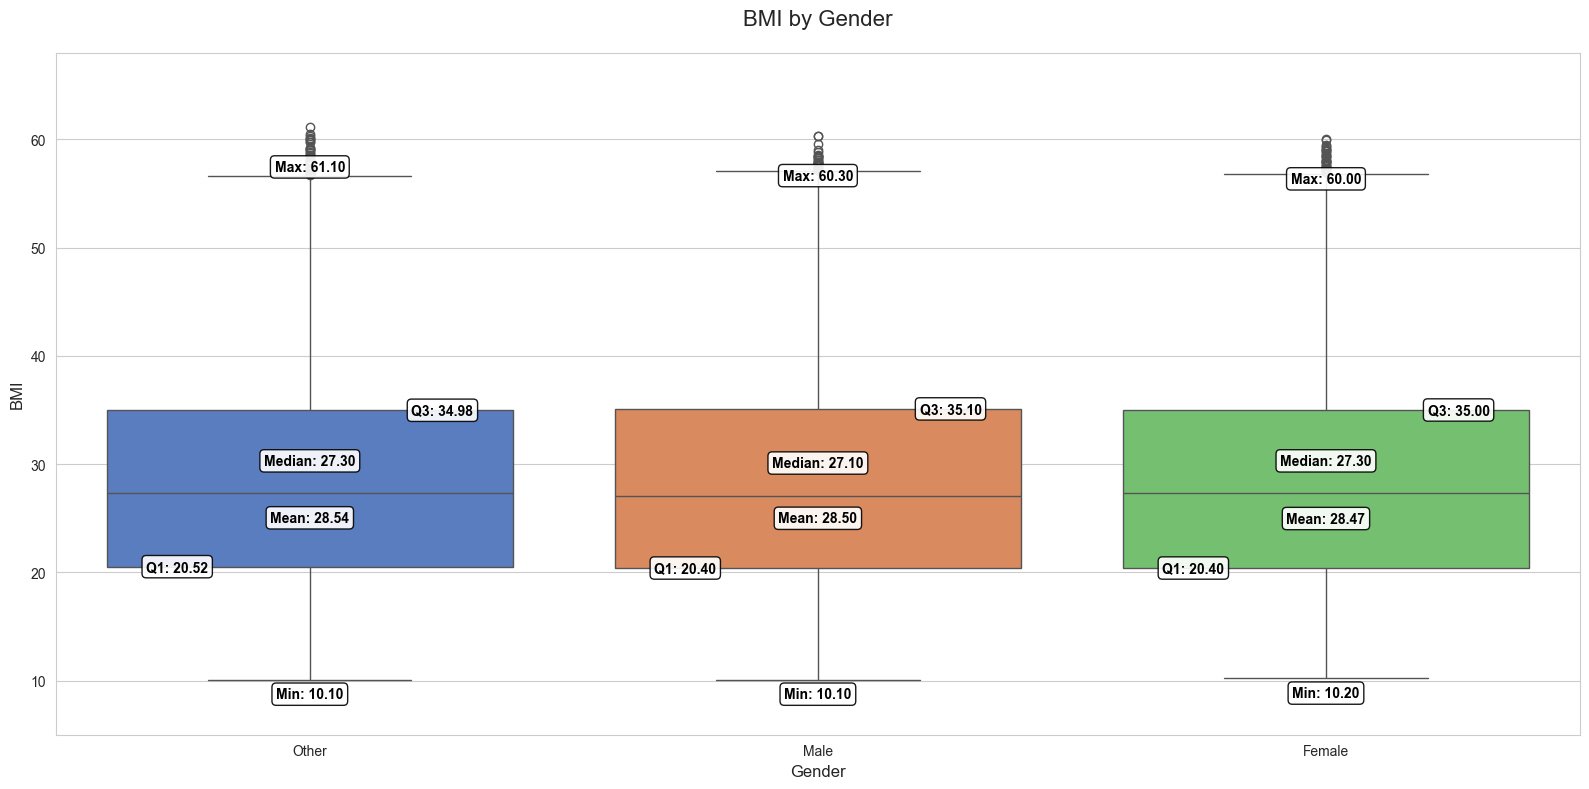

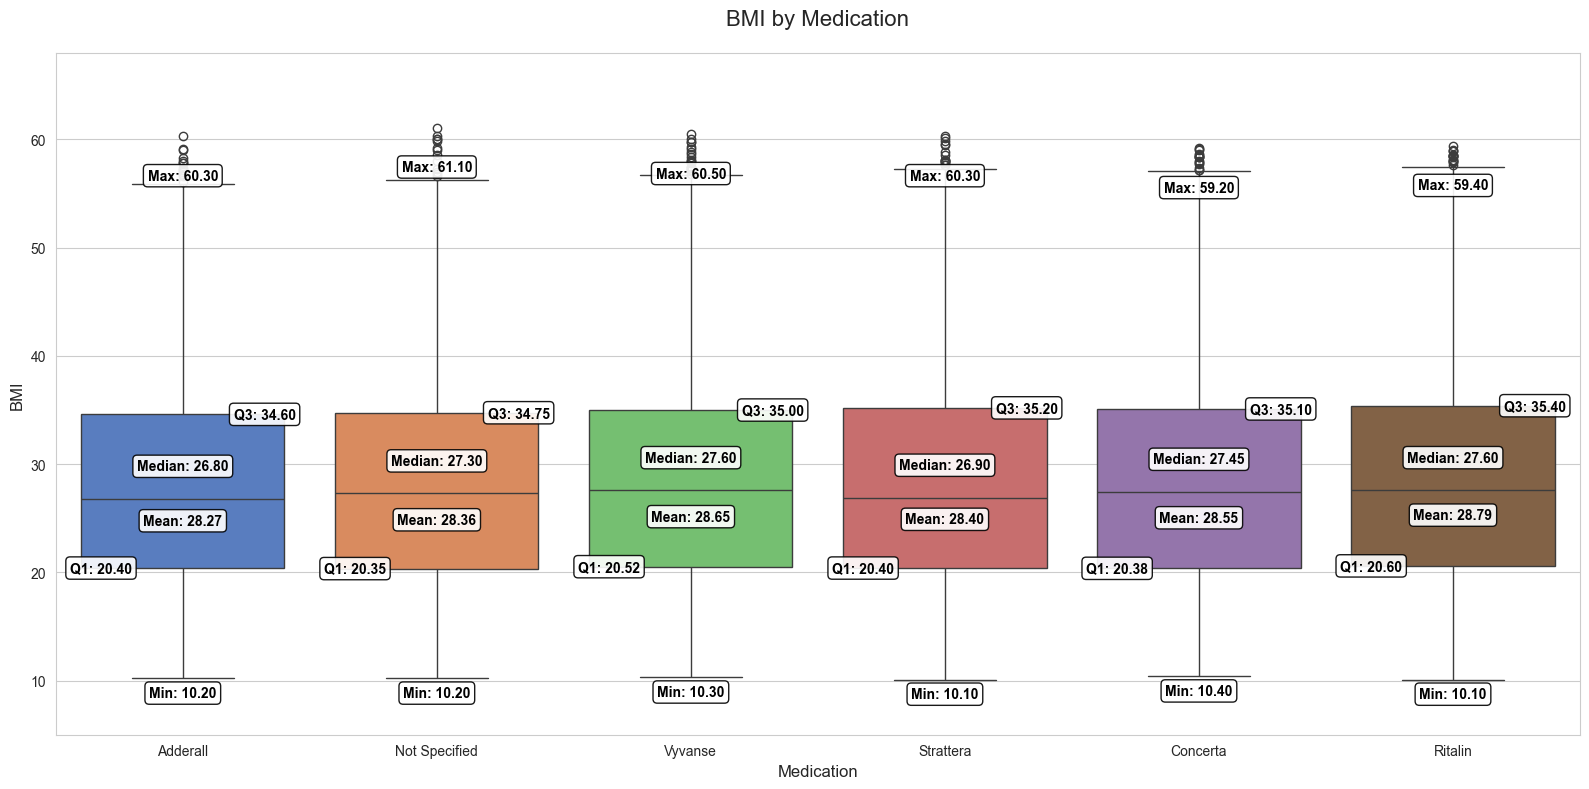

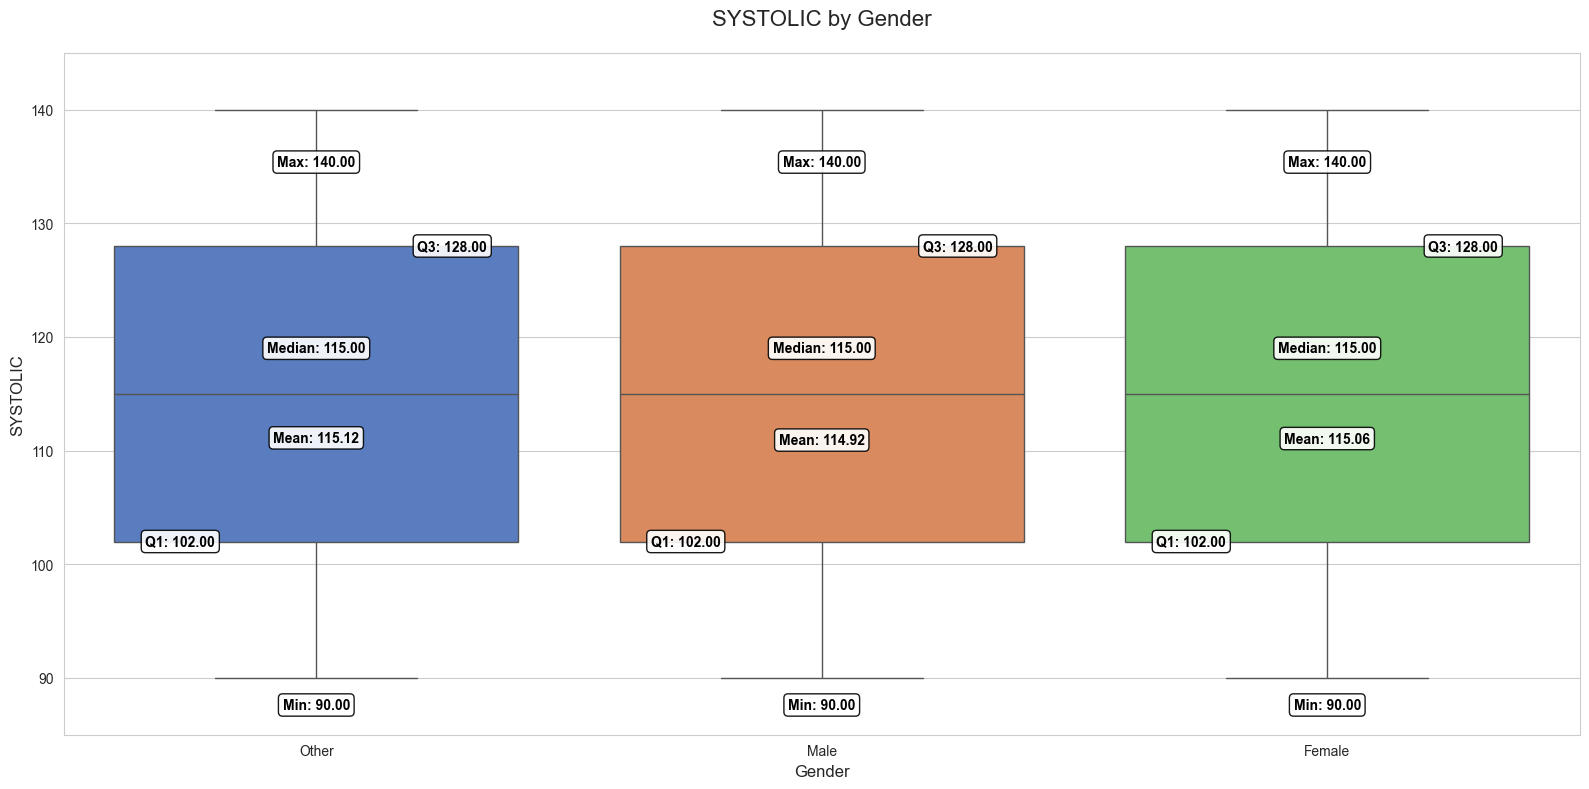

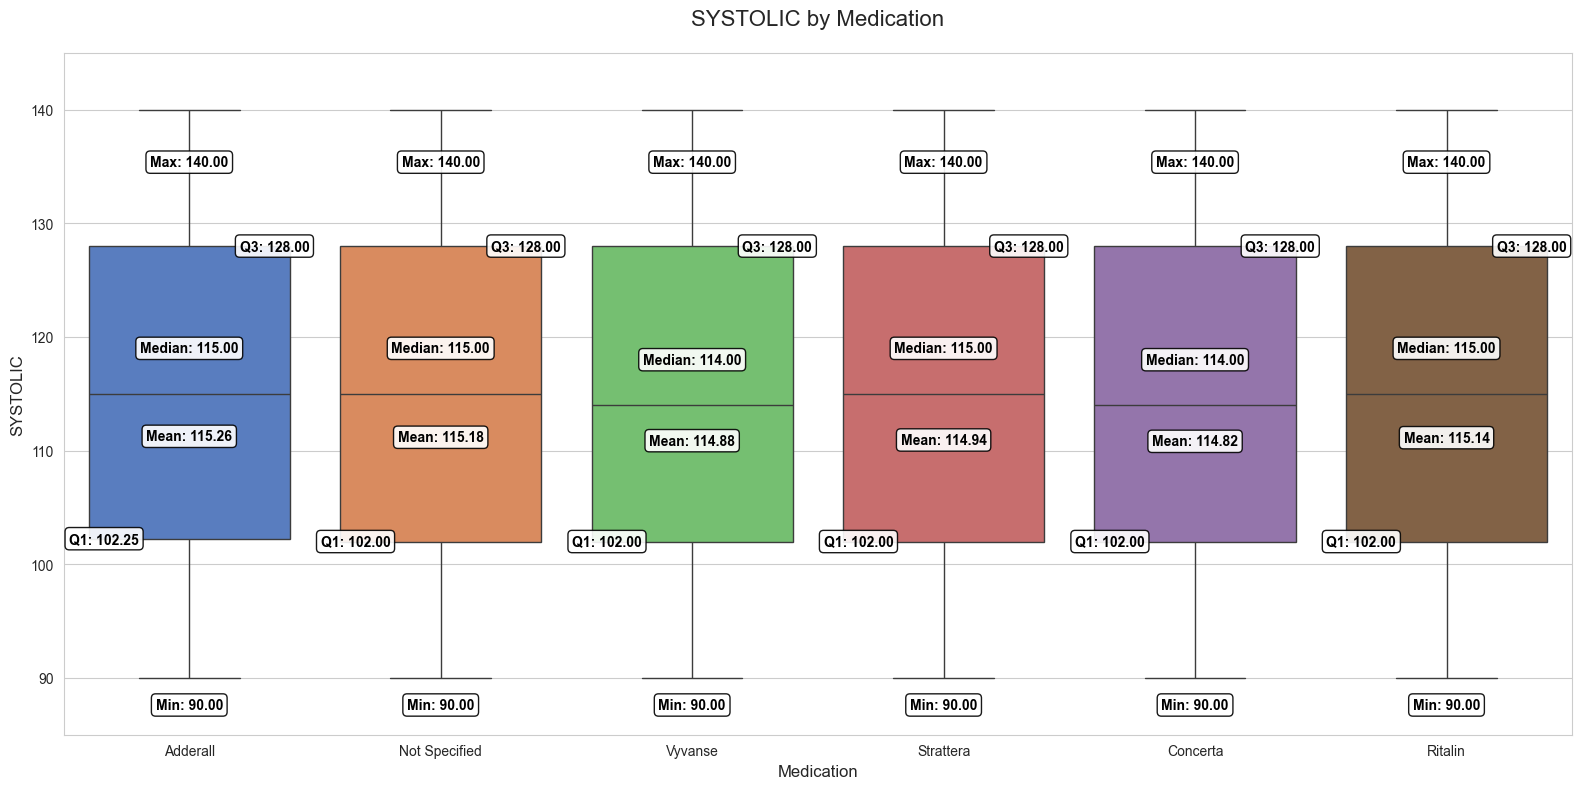

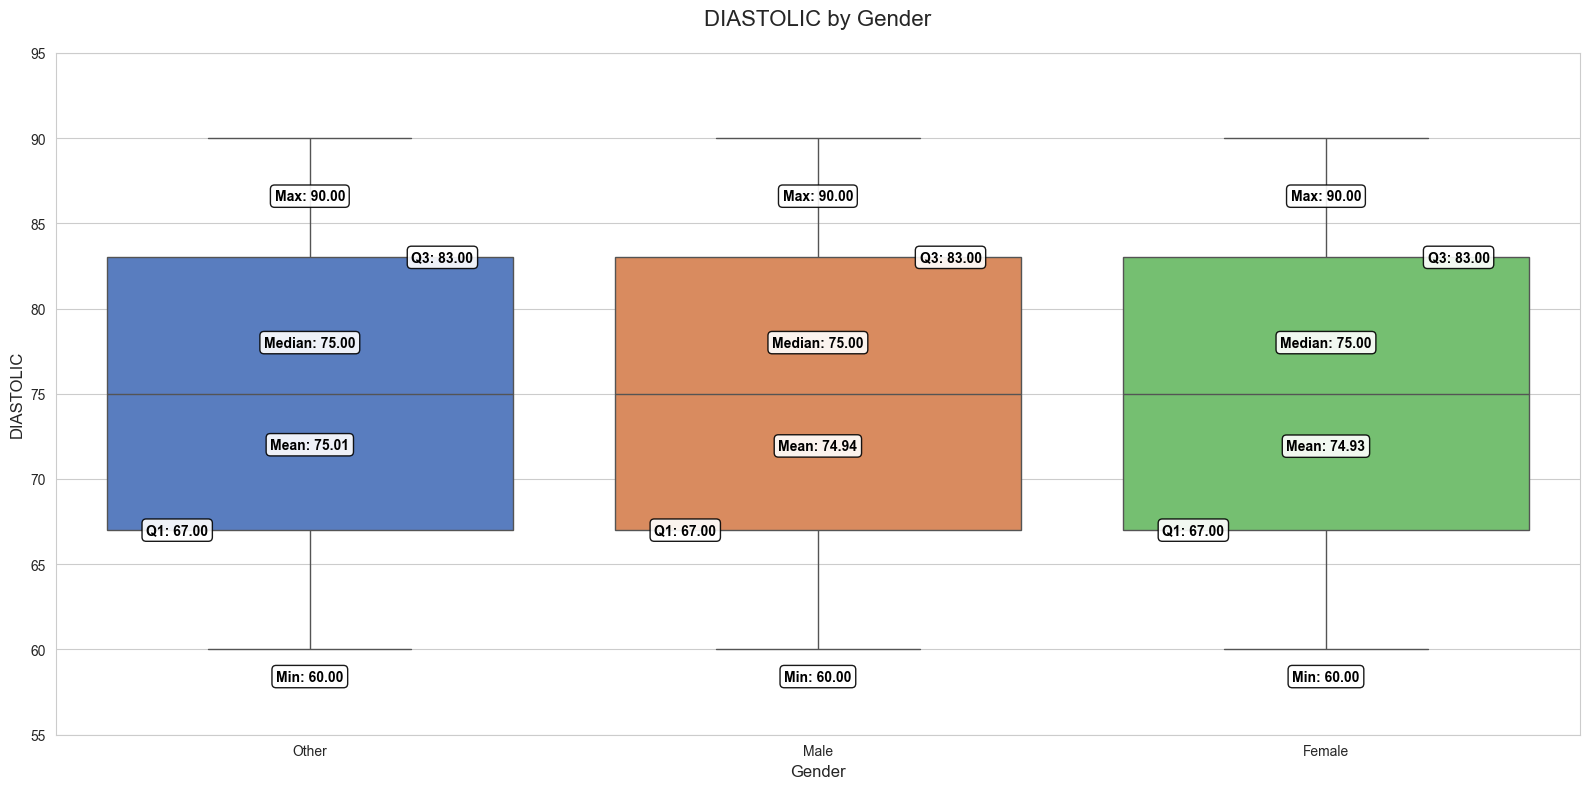

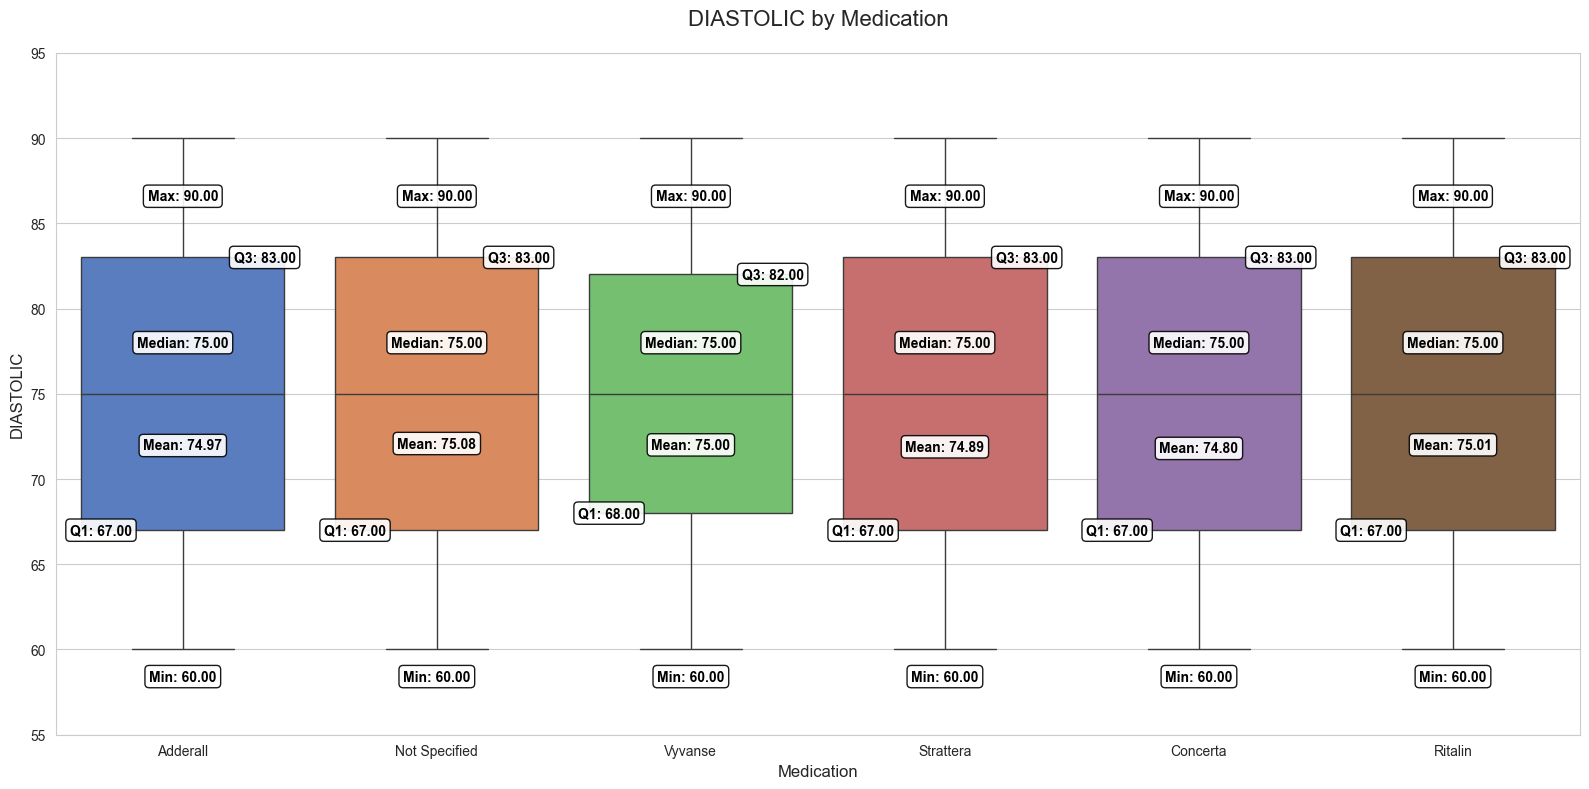

In [12]:
def plot_health_metrics(df, metrics=['bmi', 'systolic', 'diastolic'], categories=['gender', 'medication']):
    sns.set_style("whitegrid")
    palette = sns.color_palette("muted")
    # metric settings
    bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1, alpha=0.9)
    metric_settings = {
        'bmi': {
            'range': (5, 68),
            'offsets': (-2, -3),
            'text_positions': (-3.5, 3)
        },
        'systolic': {
            'range': (85, 145),  
            'offsets': (-3, -4),
            'text_positions': (-4, 4)
        },
        'diastolic': {
            'range': (55, 95),  
            'offsets': (-2, -3),
            'text_positions': (-3, 3)
        }
    }
    
    # combinations of metrics and categories
    combinations = [(metric, factor) for metric in metrics for factor in categories]
    
    for metric, factor in combinations:
        plt.figure(figsize=(16, 8))
        ax = sns.boxplot(x=factor, y=metric, data=df, palette=palette)
        plt.title(f'{metric.upper()} by {factor.capitalize()}', fontsize=16, pad=20)
        
        settings = metric_settings.get(metric, {
            'range': (None, None),
            'offsets': (-3, -4),
            'text_positions': (-4, 4)
        })
        
        plt.ylim(*settings['range'])
        
        # Calculate the statistics for each specified categorical column
        categories = df[factor].unique()
        
        for category in categories:
            cat_data = df[df[factor] == category][metric]
            min_val = np.min(cat_data)
            q1 = np.percentile(cat_data, 25)
            median = np.percentile(cat_data, 50)
            q3 = np.percentile(cat_data, 75)
            max_val = np.max(cat_data)
            mean_val = np.mean(cat_data)
            x_pos = list(categories).index(category)
            min_offset, max_offset = settings['offsets']
            mean_text_y, median_text_y = settings['text_positions']

            # Min value
            ax.annotate(f'Min: {min_val:.2f}', xy=(x_pos, min_val), xytext=(x_pos, min_val + min_offset), 
                        ha='center', va='bottom', color='black', fontweight='bold', bbox=bbox_props)

            # Q1 value
            ax.annotate(f'Q1: {q1:.2f}', xy=(x_pos, q1), xytext=(x_pos - 0.2, q1), ha='right', 
                        va='center', color='black', fontweight='bold', bbox=bbox_props)

            # Median value
            ax.annotate(f'Median: {median:.2f}', xy=(x_pos, median), xytext=(x_pos, median + median_text_y),
                        ha='center', va='center', color='black', fontweight='bold', bbox=bbox_props)

            # Mean value
            ax.annotate(f'Mean: {mean_val:.2f}', xy=(x_pos, mean_val), xytext=(x_pos, mean_val + mean_text_y), 
                        ha='center', va='center', color='black', fontweight='bold', bbox=bbox_props)

            # Q3 value
            ax.annotate(f'Q3: {q3:.2f}', xy=(x_pos, q3), xytext=(x_pos + 0.2, q3), ha='left', 
                        va='center', color='black', fontweight='bold', bbox=bbox_props)

            # Max value
            ax.annotate(f'Max: {max_val:.2f}', xy=(x_pos, max_val), xytext=(x_pos, max_val + max_offset), 
                        ha='center', va='top', color='black', fontweight='bold', bbox=bbox_props)

        plt.ylabel(metric.upper(), fontsize=12)
        plt.xlabel(factor.capitalize(), fontsize=12)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.tight_layout()
        plt.show()

plot_health_metrics(patient_df_clean)

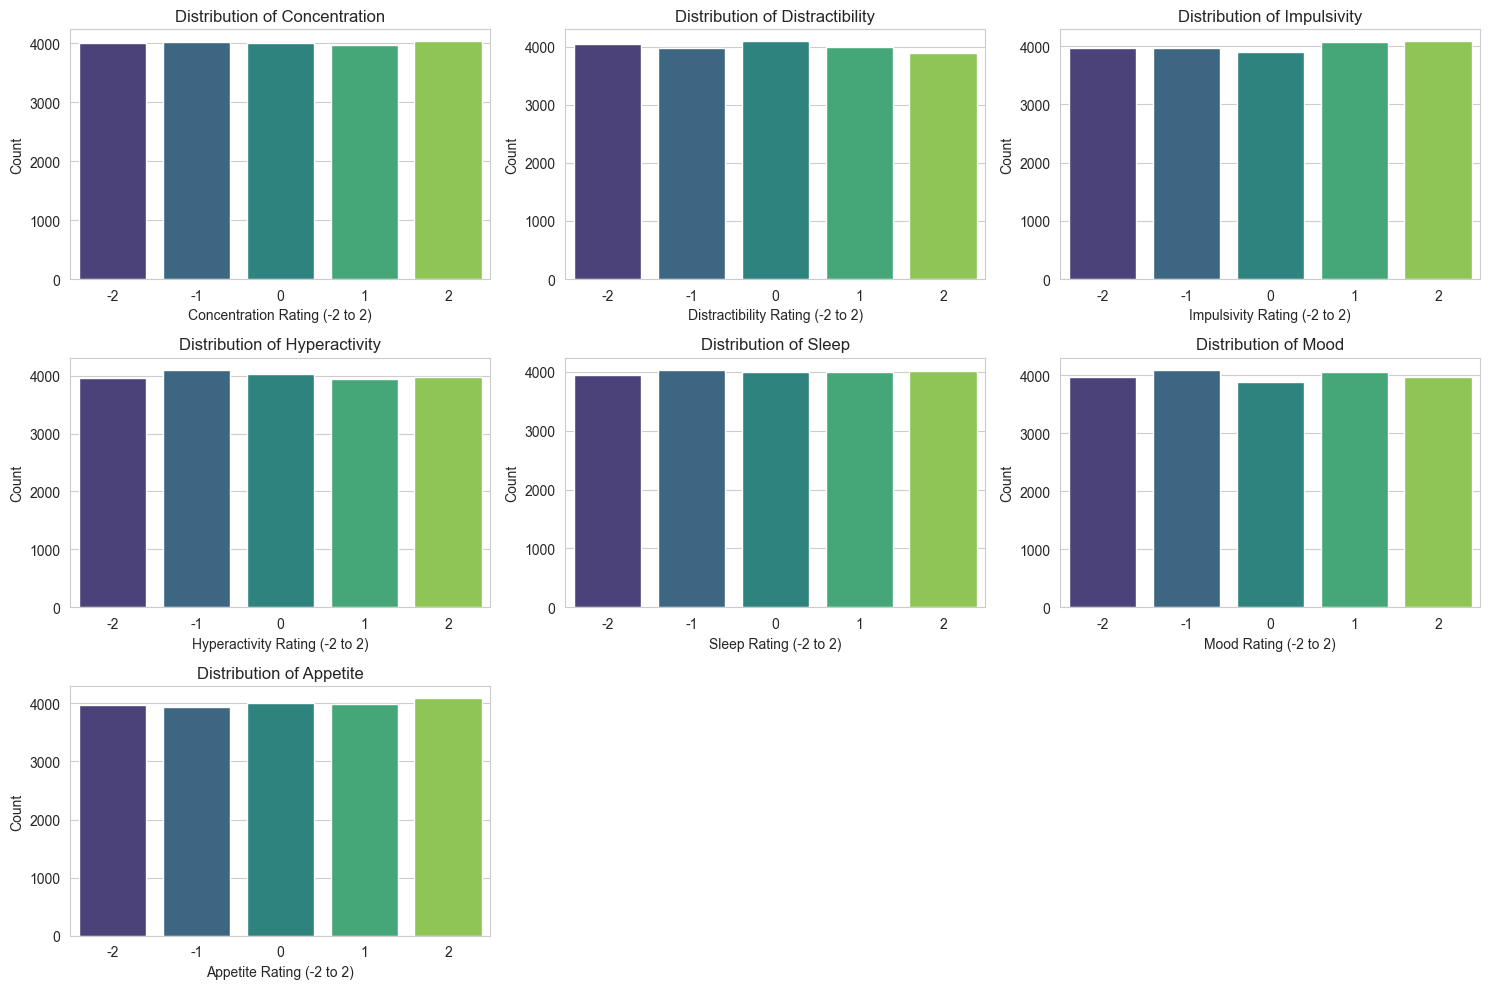

In [13]:
# Distribution of Behavioral Ratings
behavior_cols = ['concentration', 'distractibility', 'impulsivity', 'hyperactivity', 
                 'sleep', 'mood', 'appetite']

plt.figure(figsize=(15, 10))
for i, col in enumerate(behavior_cols, 1):
    plt.subplot(3, 3, i)
    sns.countplot(x=patient_df_clean[col], palette='viridis')
    plt.title(f'Distribution of {col.capitalize()}')
    plt.xlabel(f'{col.capitalize()} Rating (-2 to 2)')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

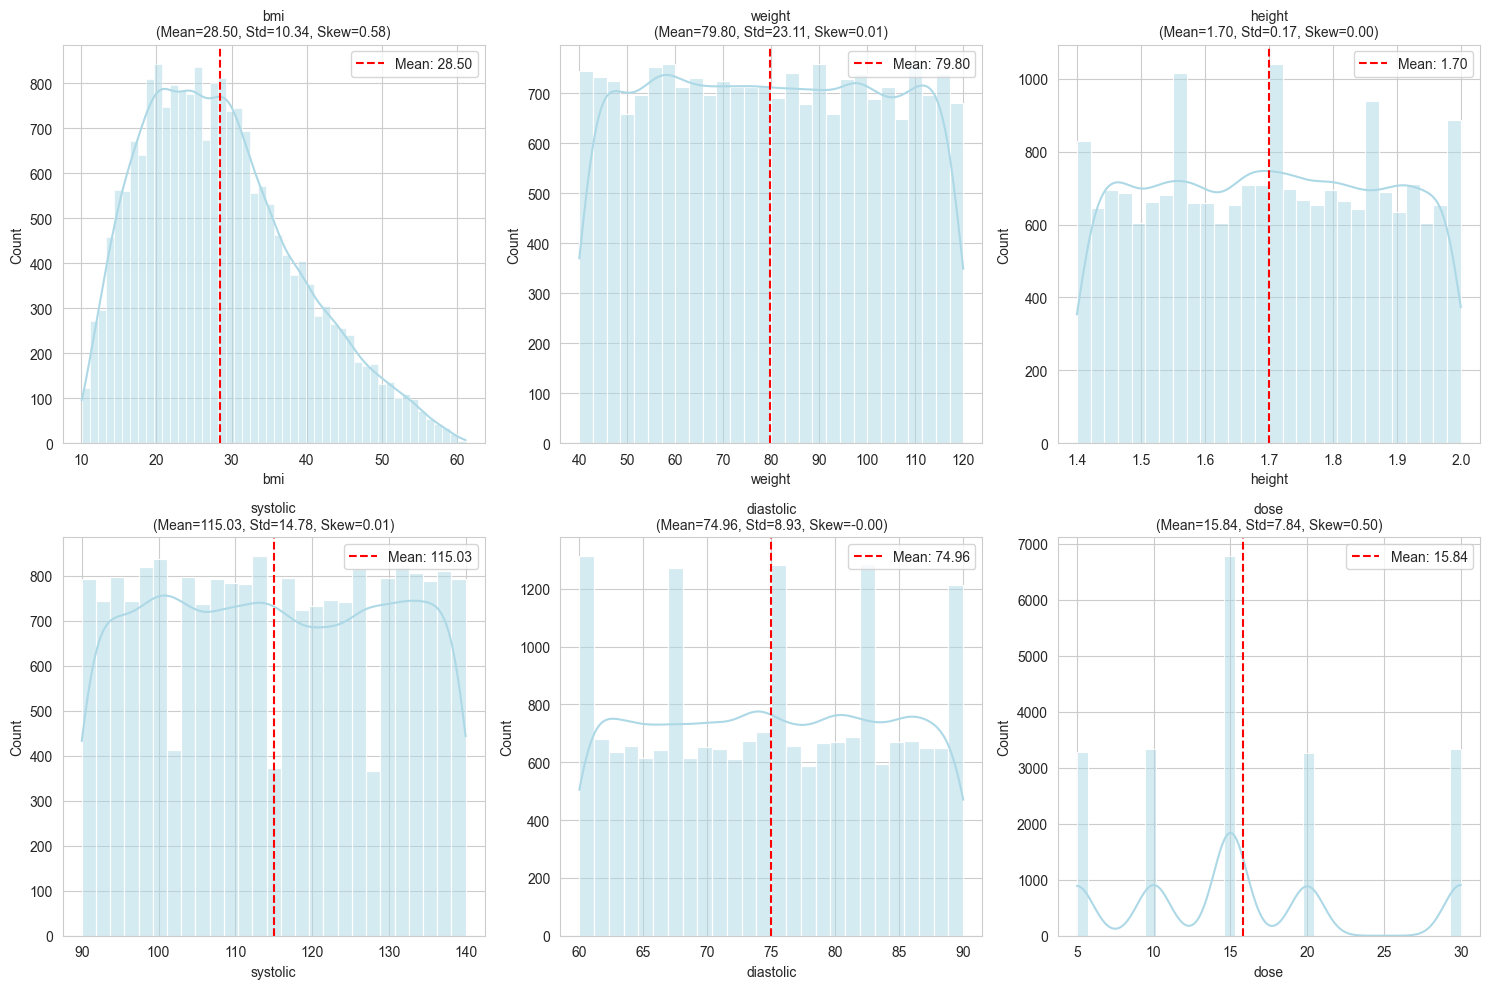

In [20]:
def plot_distribution(df, columns, rows=2, cols=3):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    axes = axes.flatten()  

    for i, column in enumerate(columns):
        col_mean = df[column].mean()
        col_std = df[column].std()
        col_skew = skew(df[column])
        sns.histplot(df[column], kde=True, color='lightblue', ax=axes[i])
        axes[i].set_title(f'{column}\n(Mean={col_mean:.2f}, Std={col_std:.2f}, Skew={col_skew:.2f})', fontsize=10)
        axes[i].axvline(col_mean, color='red', linestyle='--', label=f'Mean: {col_mean:.2f}')
        axes[i].legend()

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

columns_to_plot = ['bmi', 'weight', 'height', 'systolic', 'diastolic','dose']
plot_distribution(patient_df_clean, columns_to_plot)

### 3. Visualisations:
- Correlation heatmap between behaviour fields.
- Boxplot: concentration vs medication.
- Scatter plot: BMI vs systolic, coloured by hyperactivity.


#### Insights

The behaviorial ratings features (-2 to 2 ) are ordinal data, they represent ranked categories (ratings), so I used Spearman’s ρ (rank correlation) for correlation because it considers the order of values, not their absolute magnitudes, making it robust for non-linear but monotonic relationships.

- The correlation matrix shows that all the correlation coefficients are very close to zero (around 0.01 or -0.01), this suggests that a patient's ranking in one behavioral trait (e.g., concentration) is generally not predictive of their ranking in another trait (e.g., mood). These behavioral features appear to be independent of each other within this patient group.


- The boxplot for concentration vs medication shows that all medications (Adderall, Vyvanse, Strattera, Concerta, and Ritalin) show similar median concentration rating around 0. The consistency across medications suggests that in this dataset, no single medication demonstrates clearly superior effects on concentration rating.
-  The scatter plot for BMI vs systolic by hyperactivity, shows that there is no strong linear correlation between BMI and systolic blood pressure visible in this data. The data points are distributed fairly evenly across the graph, suggesting diverse patient profiles. The absence of clear patterns suggest that individual patient responses to medications are variable, reinforcing the need for personalized treatment approaches.

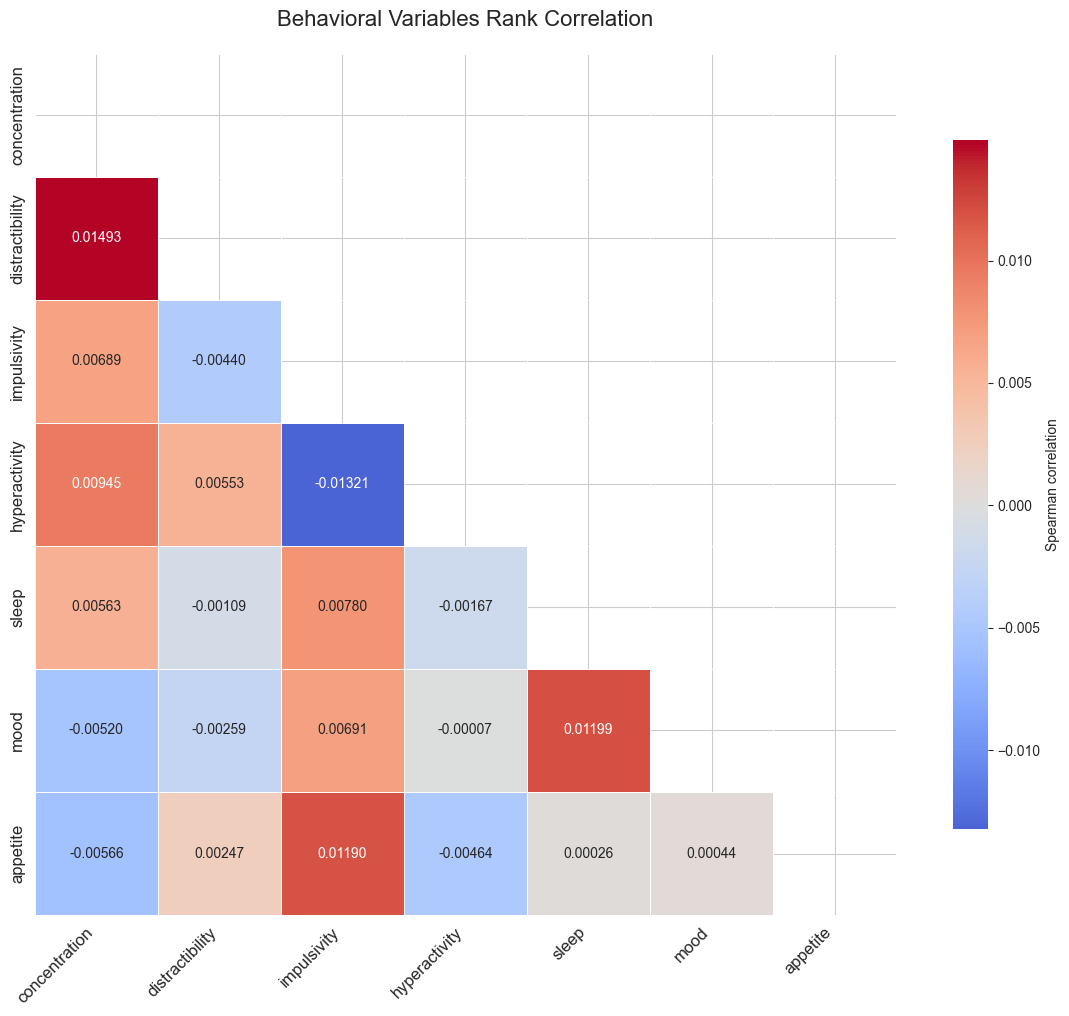

In [14]:
# Correlation heatmap between behaviour fields.
def plot_spearman_heatmap(df, behavior_cols):
    """
    Plot Spearman's rank correlation heatmap for behavioral variables (-2 to 2 scale).

    """
    df_behaviors = df[behavior_cols]
    corr_matrix = np.zeros((len(behavior_cols), len(behavior_cols)))
    p_matrix = np.zeros((len(behavior_cols), len(behavior_cols)))
    
    for i, col1 in enumerate(behavior_cols):
        for j, col2 in enumerate(behavior_cols):
            corr_matrix[i, j], p_matrix[i, j] = spearmanr(df_behaviors[col1], df_behaviors[col2])

    corr_df = pd.DataFrame(corr_matrix, index=behavior_cols, columns=behavior_cols)
    p_df = pd.DataFrame(p_matrix, index=behavior_cols, columns=behavior_cols)
    
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_df, dtype=bool))
    
    ax = sns.heatmap(corr_df,mask=mask,cmap='coolwarm',center=0,annot=True,fmt=".5f",square=True,
        linewidths=.5,cbar_kws={"shrink": .8, "label": "Spearman correlation"},annot_kws={"size": 10})
    
    plt.title("Behavioral Variables Rank Correlation",pad=20,fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

behavior_cols = ['concentration', 'distractibility', 'impulsivity', 'hyperactivity', 'sleep', 'mood', 'appetite']
plot_spearman_heatmap(patient_df_clean, behavior_cols)

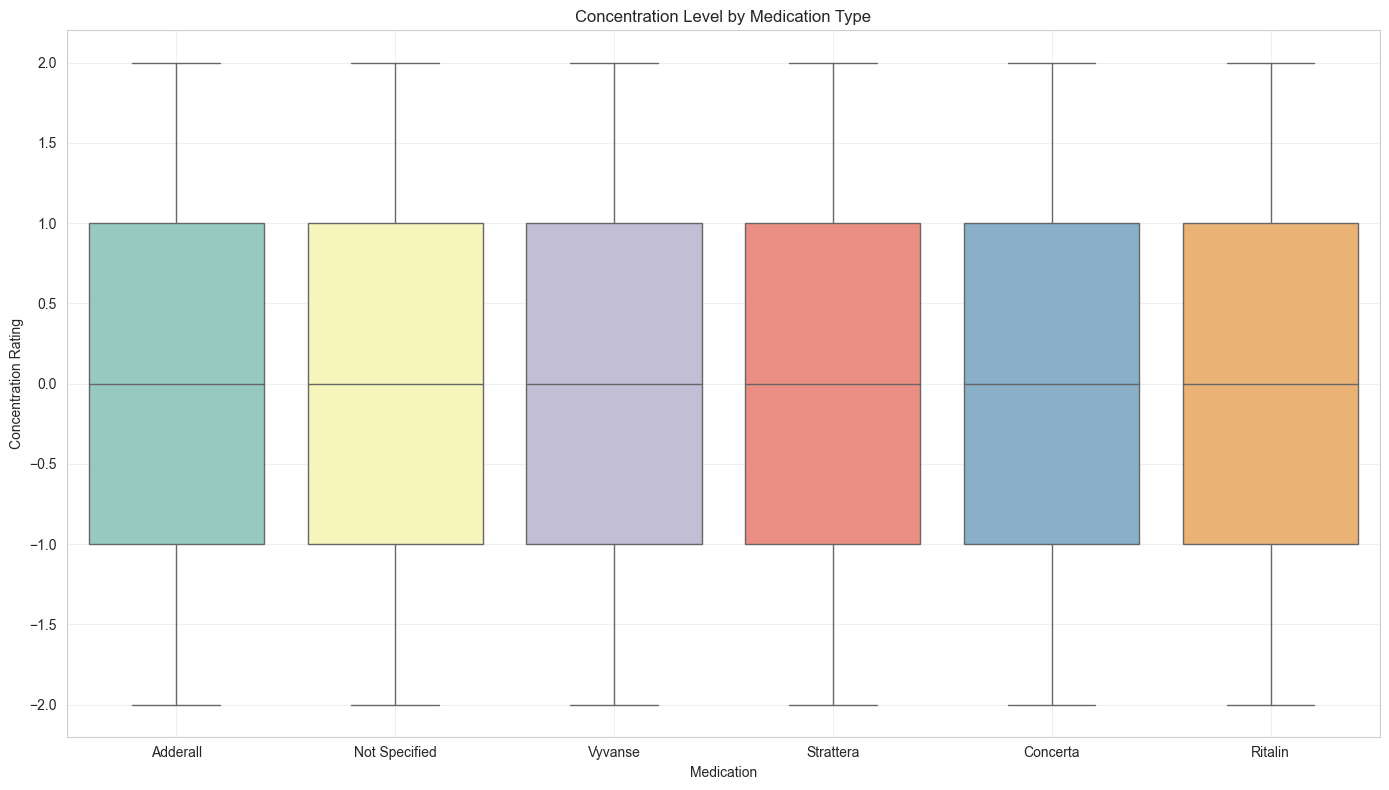

In [15]:
# Boxplot: concentration vs medication
plt.figure(figsize=(14, 8))
sns.boxplot(x='medication', y='concentration', data=patient_df_clean, palette='Set3')
plt.title('Concentration Level by Medication Type')
plt.xlabel('Medication')
plt.ylabel('Concentration Rating')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

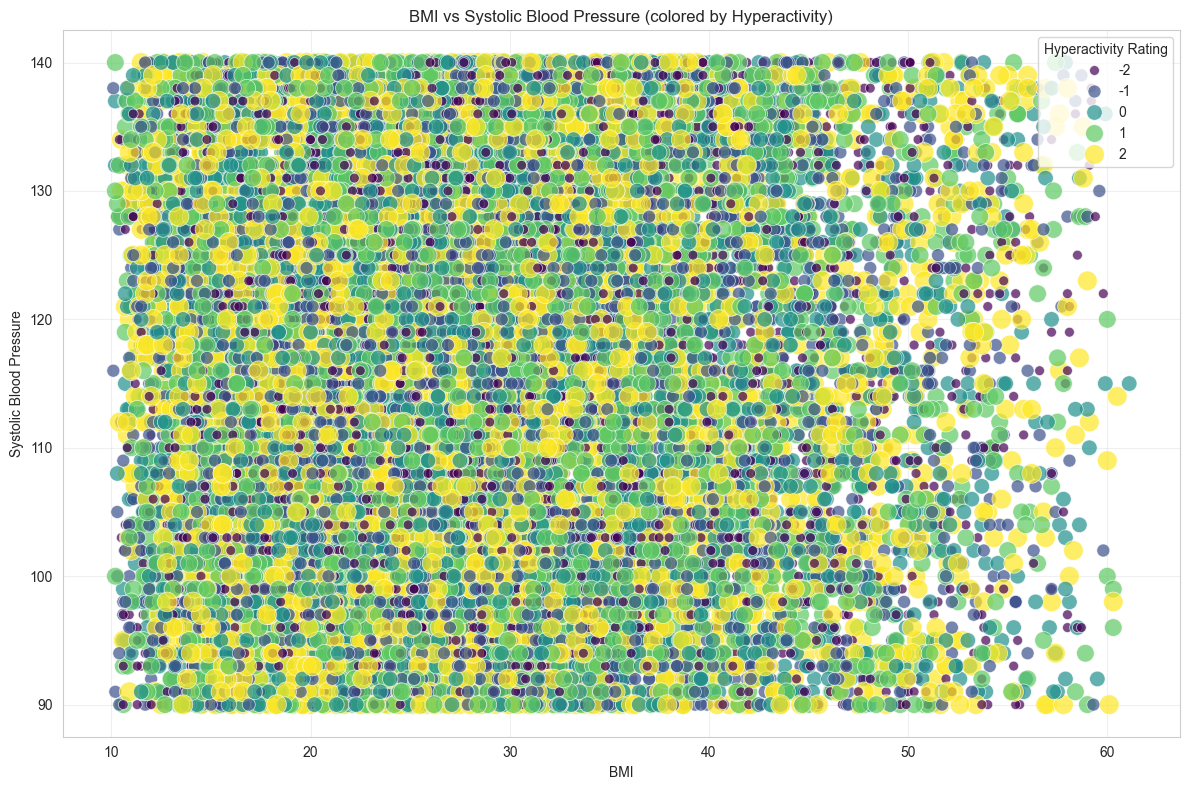

In [16]:
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(x='bmi', y='systolic', hue='hyperactivity', 
                          data=patient_df_clean, palette='viridis', size='hyperactivity',
                          sizes=(50, 200), alpha=0.7)
plt.title('BMI vs Systolic Blood Pressure (colored by Hyperactivity)')
plt.xlabel('BMI')
plt.ylabel('Systolic Blood Pressure')
plt.grid(True, alpha=0.3)
plt.legend(title='Hyperactivity Rating')
plt.tight_layout()
plt.show()

#### Insights from the doctor's notes

- Bsed on the wordcloud visual analysis on doctor's notes, core ADHD symptoms are prominently featured: "trouble sitting still", "minute," "following multi," "low," "difficulty following multi step" and "impulsivity" stand out clearly.
- Patient behavior descriptors are common: terms like "often restless," "fidgety" and "cooperative" suggest doctors are tracking behavioral patterns.
- The inability to sit still and maintain focus for even short periods ("few minutes") appears to be the most commonly documented concern.
- The frequency of "following multi step" suggests specific difficulties with sequential processing and function.

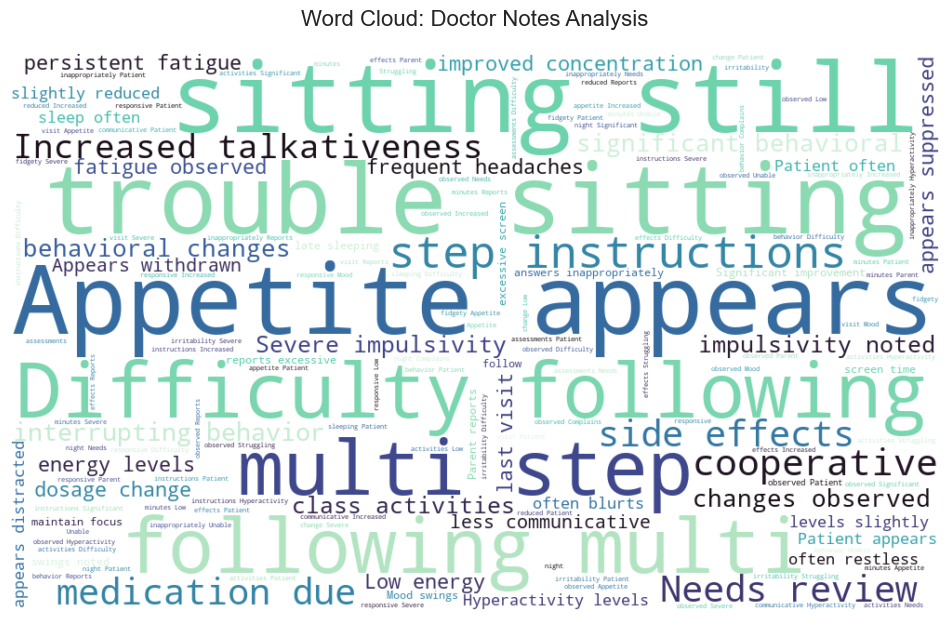

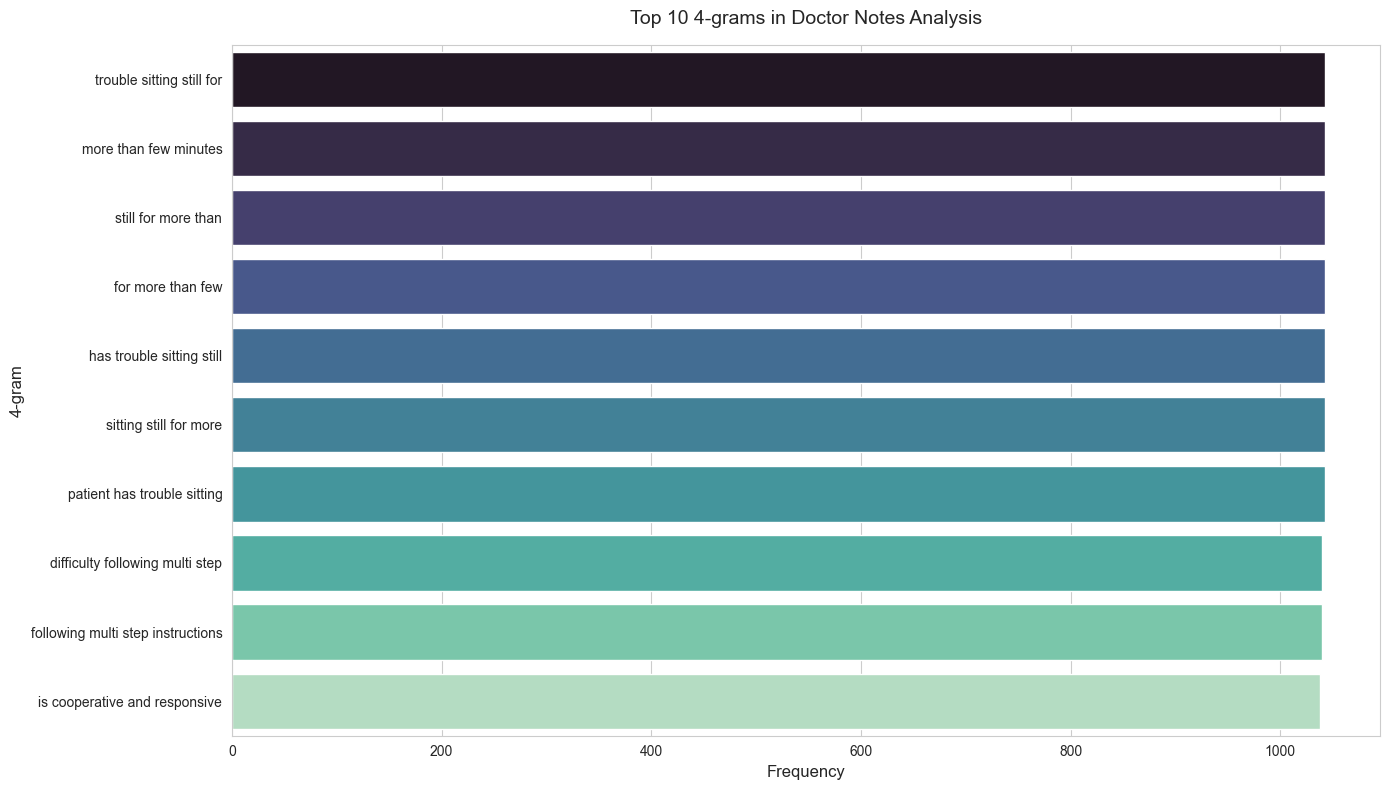

In [17]:
def perform_text_eda(df):
    """
    Perform exploratory data analysis on text fields with word clouds and n-grams
    """
    # Wordcloud Analysis on doctor notes field
    analysis_groups = {
        'doctor_notes': {
            'title': "Doctor Notes Analysis",
            'color': 'mako',
            'top_n': 20
        }
    }
    for field in analysis_groups.keys():
        if field in df.columns:
            text = " ".join(df[field].astype(str))
            plt.figure(figsize=(12, 8))
            wc = WordCloud(width=1000, 
                          height=600, 
                          background_color='white',
                          colormap=analysis_groups[field]['color'],
                          max_words=150).generate(text)
            plt.imshow(wc, interpolation='bilinear')
            plt.axis("off")
            plt.title(f"Word Cloud: {analysis_groups[field]['title']}", pad=20, fontsize=16)
            plt.show()
    
    # N-gram Analysis (4-grams)
    ngram_fields = ['doctor_notes']
    for field in ngram_fields:
        if field in df.columns:
            vec = CountVectorizer(ngram_range=(4, 4), max_features=20)
            X = vec.fit_transform(df[field].astype(str))
            fourgrams = pd.DataFrame(X.sum(axis=0), 
                                   columns=vec.get_feature_names_out()).T.sort_values(0, ascending=False)
            
            plt.figure(figsize=(14, 8))
            if not fourgrams.empty:
                sns.barplot(x=fourgrams[0][:10], 
                           y=fourgrams.index[:10], 
                           palette=analysis_groups[field]['color'])
                plt.title(f"Top 10 4-grams in {analysis_groups[field]['title']}", pad=15, fontsize=14)
                plt.xlabel("Frequency", fontsize=12)
                plt.ylabel("4-gram", fontsize=12)
                plt.tight_layout()
                plt.show()
            else:
                print(f"No 4-grams found for {field}")

perform_text_eda(patient_df_clean)